In [17]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import pickle
import gc
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [18]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

In [19]:
def exec_time(start_time):
    """Execution time in minutes"""
    return (time.time()-start_time)//60

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [20]:
# Will we save intermediate models?
save_models = True

In [21]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
print('all_data coulumns =', list(all_data.columns))
all_data.info()
all_data

all_data coulumns = ['shop_id', 'item_id', 'date_block_num', 'item_category_id', 'target', 'target_shop_date', 'target_item_date', 'target_item_shop_date', 'target_item-cat_date', 'target_shop_item-cat_date', 'target_mean', 'target_shop_date_mean', 'target_item_date_mean', 'target_item_shop_date_mean', 'target_item-cat_date_mean', 'target_shop_item-cat_date_mean', 'target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [22]:
# list(all_data.columns)

In [23]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop_date', 'target_item_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_shop_item-cat_date', 
                'target_item_date_mean', 'target_item-cat_date_mean', 'target_item-cat_date', 'target_item_shop_date', 
                'target_item_date', 'target', 'target_shop_date_mean', 'target_mean', 'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [24]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [25]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train =  all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [26]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,1.0,6.0,6.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,4.0,6.0,6.0,4.0,4.0,4.0,4.0,...,0.0,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,9,15,7,0,0,31,0.000000


In [27]:
# del all_data
gc.collect()

97

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [28]:
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']

print('cat_features =', cat_features)
print('cat_columns =', cat_columns)
for cat in cat_columns:
    print('for category ', cat, 'found unique values:', X_train[cat].unique().shape[0])

cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
cat_columns = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'type_code', 'subtype_code']
for category  shop_id found unique values: 54
for category  item_id found unique values: 16561
for category  item_category_id found unique values: 79
for category  city_code found unique values: 31
for category  type_code found unique values: 19
for category  subtype_code found unique values: 62


In [12]:
%%time
# Linear regresson
model_lr = make_pipeline(
    #OneHotEncoder(),
    MinMaxScaler(),
    LinearRegression(n_jobs=-1),
    verbose=True,
)
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

print('\nTest R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))

if save_models:
    pickle.dump(model_lr, open('data/sa-model_lr.pkl', "wb"))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   3.3s
[Pipeline] .. (step 2 of 2) Processing linearregression, total=  28.2s

Test R-squared for linreg is 0.279029
Test RMSE linreg is 0.964709
CPU times: user 1min 3s, sys: 8.8 s, total: 1min 12s
Wall time: 31.6 s


In [43]:
%%time
# Keras from tensorflow
ts = time.time()
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def BuildModel():
 model = Sequential()
#  model.add(Dense(128, input_dim=3,activation='relu')) 
#  model.add(Dense(32, activation='relu')) 
#  model.add(Dense(8, activation='relu')) 
#  model.add(Dense(1, activation='linear'))
 model.add(Dense(200, activation='relu')) 
 model.compile(loss="mean_squared_error", optimizer="adam",)   
 return model

# inputs = keras.Input()

# regressor = KerasRegressor(build_fn=BuildModel,nb_epoch=100,batch_size=3)
# regressor.fit(x,y) 

model_kr = make_pipeline(
    StandardScaler(),
    KerasRegressor(
        build_fn=BuildModel,
        #nb_epoch=100,
        #batch_size=3,
        validation_data=(X_test, y_test),
        use_multiprocessing=True,
        workers=4,
        verbose=1,
    ),
    verbose=True,
)
model_kr.fit(
    X_train, y_train,
    #use_multiprocessing=True,
    #workers=4
)
pred_kr = model_kr.predict(X_test)
train_kr = model_kr.predict(X_train)

print('Test R-squared is %f' % r2_score(y_test, pred_kr))
print('Train R-squared is %f' % r2_score(y_train, train_kr))
print(f'Test RMSE is {np.sqrt(mean_squared_error(y_test, pred_kr)):.6}')
print(f'Train RMSE is {rmse(y_train, train_kr):.6}',
         f'execution time {exec_time(ts)} minutes')

if save_models:
    pickle.dump(model_kr, open('data/sa-model_kr.pkl', "wb"))

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   7.1s
Train on 6186922 samples, validate on 238172 samples
6186922/6186922 [==============================] - 1477s 239us/sample - loss: 0.9203 - val_loss: 167543.0281
[Pipeline] .... (step 2 of 2) Processing kerasregressor, total=24.6min
6186922/6186922 [==============================] - 451s 73us/sample


ValueError: y_true and y_pred have different number of output (1!=200)

In [ ]:
model_performance_sc_plot(pred_kr, y_test, 'Test')

In [13]:
%%time
from sklearn.neural_network import MLPRegressor

model_mlp = make_pipeline(
    MinMaxScaler(),
    MLPRegressor(
        random_state=47, 
        verbose=True,
        early_stopping=True,
        n_iter_no_change=5,
        solver='adam',
#         hidden_layer_sizes=(300, 200 ,100), alpha=0.03, learning_rate='adaptive', learning_rate_init=0.0005, 
#         max_iter=200, momentum=0.9, nesterovs_momentum=True,
    ),
    verbose=True,
)
model_mlp.fit(X_train, y_train)
pred_mlp = model_mlp.predict(X_test)
train_mlp = model_mlp.predict(X_train)

print('Test R-squared is %f' % r2_score(y_test, pred_mlp))
print('Train R-squared is %f' % r2_score(y_train, train_mlp))
print(f'Test RMSE is {np.sqrt(mean_squared_error(y_test, pred_mlp)):.6}')
print(f'Train RMSE is {np.sqrt(mean_squared_error(y_train, train_mlp)):.6}')

if save_models:
    pickle.dump(model_mlp, open('data/sa-model_mlp.pkl', "wb"))

[Pipeline] ...... (step 1 of 2) Processing minmaxscaler, total=   3.3s
Iteration 1, loss = 0.40504097
Validation score: 0.433181
Iteration 2, loss = 0.39058312
Validation score: 0.446674
Iteration 3, loss = 0.38460675
Validation score: 0.451215
Iteration 4, loss = 0.38063824
Validation score: 0.458092
Iteration 5, loss = 0.37769591
Validation score: 0.461678
Iteration 6, loss = 0.37499981
Validation score: 0.465535
Iteration 7, loss = 0.37289355
Validation score: 0.463071
Iteration 8, loss = 0.37144070
Validation score: 0.468284
Iteration 9, loss = 0.37017903
Validation score: 0.470307
Iteration 10, loss = 0.36908898
Validation score: 0.470663
Iteration 11, loss = 0.36808530
Validation score: 0.473723
Iteration 12, loss = 0.36730323
Validation score: 0.470249
Iteration 13, loss = 0.36659489
Validation score: 0.475908
Iteration 14, loss = 0.36602787
Validation score: 0.477453
Iteration 15, loss = 0.36541763
Validation score: 0.479127
Iteration 16, loss = 0.36496405
Validation score: 0.4

In [14]:
%%time
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
# linear_features = ['target_item_date_lag_1', 'delta_price_lag', 
#                 'target_lag_1', 'target_lag_2', 'item_category_id',  'target_mean_lag_1',
#                 'target_mean_lag_2',
#                 'target_item_date_mean_lag_1', 'target_item_date_mean_lag_2',  
#                 'target_item_shop_date_lag_1', 'target_item_shop_date_lag_2',
#                'target_shop_date_mean_lag_1']
# linear_features = ['target_lag_1', 'target_item-cat_date_lag_1', 'target_item-cat_date_mean_lag_1', 
#                    'target_item_date_lag_1', 'target_item_date_mean_lag_1', 'target_item_shop_date_lag_1', 
#                    'target_item_shop_date_mean_lag_1', 'target_mean_lag_1', 'target_shop_date_lag_1', 
#                    'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_lag_1', 'target_shop_item-cat_date_mean_lag_1', 
#                    'target_lag_2', 'target_item-cat_date_lag_2', 'target_item-cat_date_mean_lag_2', 'target_item_date_lag_2', 
#                    'target_item_date_mean_lag_2', 'target_item_shop_date_lag_2', 'target_item_shop_date_mean_lag_2', 
#                    'target_mean_lag_2', 'target_shop_date_lag_2', 'target_shop_date_mean_lag_2', 'target_shop_item-cat_date_lag_2', 
#                    'target_shop_item-cat_date_mean_lag_2']

linear_features = ['target_lag_1', 'target_item-cat_date_mean_lag_1', 
                   'target_item_date_mean_lag_1', 
                   'target_item_shop_date_mean_lag_1', 'target_mean_lag_1',
                   'target_shop_date_mean_lag_1', 'target_shop_item-cat_date_mean_lag_1', 
                   'target_lag_2', 'target_item-cat_date_mean_lag_2', 
                   'target_item_date_mean_lag_2', 'target_item_shop_date_mean_lag_2', 
                   'target_mean_lag_2', 'target_shop_date_mean_lag_2', 
                   'target_shop_item-cat_date_mean_lag_2',
                   'target_lag_3', 'target_item-cat_date_mean_lag_3', 'target_item_date_mean_lag_3', 
                   'target_item_shop_date_mean_lag_3', 'target_mean_lag_3', 'target_shop_date_mean_lag_3', 
                   'target_shop_item-cat_date_mean_lag_3',
                   'days', 'delta_price_lag']



model_lrc = make_pipeline(
    ColumnTransformer([
         ('one_hot_item_category_id', OneHotEncoder(), ['item_category_id']),
         ('one_hot_city_code', OneHotEncoder(), ['city_code']),
         ('one_hot_type_code', OneHotEncoder(), ['type_code']),
         ('to_pass', 'passthrough', linear_features)
        ], remainder='drop', n_jobs=-1, 
        sparse_threshold=0.3,
        verbose=True),
    MaxAbsScaler(),
    LinearRegression(n_jobs=-1),
    #ElasticNetCV(n_jobs=-1, random_state=43, max_iter=1000),
    #BayesianRidge(),
    verbose=True,
)
model_lrc.fit(X_train, y_train)
pred_lrc = model_lrc.predict(X_test)

print('\nTest R-squared for linreg is %f' % r2_score(y_test, pred_lrc))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lrc)))

if save_models:
    pickle.dump(model_lrc, open('data/sa-model_lrc.pkl', "wb"))

[Pipeline] . (step 1 of 3) Processing columntransformer, total=   9.2s
[Pipeline] ...... (step 2 of 3) Processing maxabsscaler, total=   3.1s
[Pipeline] .. (step 3 of 3) Processing linearregression, total= 2.6min

Test R-squared for linreg is 0.277824
Test RMSE linreg is 0.965515
CPU times: user 3min 6s, sys: 48.6 s, total: 3min 55s
Wall time: 2min 49s


In [42]:
%%time
# BayesianRidge regression
ts=time.time()
from sklearn.linear_model import BayesianRidge

model_br = make_pipeline(
    MinMaxScaler(), 
    BayesianRidge() #n_iter=1000, tol=0.0001)
)

model_br.fit(X_train, y_train)
pred_br = model_br.predict(X_test)

print(f'Test BayesianRidge linreg is {np.sqrt(mean_squared_error(y_test, pred_br)):.6f}' )

if save_models:
    pickle.dump(model_br, open('data/sa-model_br.pkl', "wb"))
exec_time(ts)

Test BayesianRidge linreg is 0.964709
CPU times: user 2min 13s, sys: 13 s, total: 2min 26s
Wall time: 48.1 s


0.0

In [16]:
%%time
# ElasticNetCV
from sklearn.linear_model import ElasticNetCV

model_en = make_pipeline(
    StandardScaler(), 
    ElasticNetCV(n_jobs=-1, random_state=43, max_iter=1000)
)
model_en.fit(X_train.values, y_train)
pred_en = model_en.predict(X_test.values)

print('Test ElasticNet linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_en)))

if save_models:
    pickle.dump(model_en, open('data/sa-model_en.pkl', "wb"))

Test ElasticNet linreg is 0.965580
CPU times: user 6min 44s, sys: 1min 8s, total: 7min 52s
Wall time: 3min


In [17]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

model_lcv =  make_pipeline(
    StandardScaler(),
    LassoCV(n_jobs=4, random_state=43)
)
model_lcv.fit(X_train.values, y_train)
pred_lcv = model_lcv.predict(X_test.values)

print('Test LassoCV is %f' % np.sqrt(mean_squared_error(y_test, pred_lcv)))

if save_models:
    pickle.dump(model_lcv, open('data/sa-model_lcv.pkl', "wb"))

Test LassoCV is 0.965963
CPU times: user 2min 15s, sys: 30 s, total: 2min 45s
Wall time: 1min 20s


In [18]:
%%time
# RidgeCV
from sklearn.linear_model import RidgeCV

model_rcv =  make_pipeline(
    StandardScaler(),
    RidgeCV(scoring='neg_mean_squared_error')
)
model_rcv.fit(X_train.values, y_train)
pred_rcv = model_rcv.predict(X_test.values)

print('Test RidgeCV is %f' % np.sqrt(mean_squared_error(y_test, pred_rcv)))

if save_models:
    pickle.dump(model_rcv, open('data/sa-model_rcv.pkl', "wb"))

Test RidgeCV is 0.964709
CPU times: user 2min 20s, sys: 17.4 s, total: 2min 38s
Wall time: 1min 8s


## Tree-based models

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.927765
[200]	valid_0's l2: 0.876133
[300]	valid_0's l2: 0.86312
[400]	valid_0's l2: 0.857993
[500]	valid_0's l2: 0.857186
[600]	valid_0's l2: 0.860278
Early stopping, best iteration is:
[534]	valid_0's l2: 0.855937

Test R-squared for LightGBM is 0.336919
Test RMSE LightGBM is 0.925169

CPU times: user 17min 38s, sys: 10.1 s, total: 17min 48s
Wall time: 5min 4s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

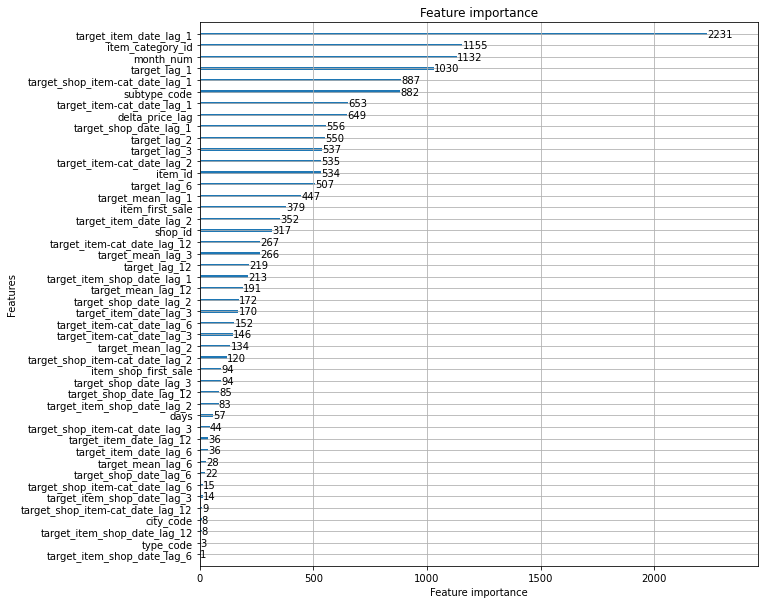

In [19]:
%%time
# LightGBM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    #num_leaves=60,
    n_jobs=-1,
    objective='mse',
    random_state=43
)

model_lgb.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    early_stopping_rounds=100,
    verbose=100
)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [20]:
#model_lgb.get_params()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0910983	test: 1.0723190	best: 1.0723190 (0)	total: 1.09s	remaining: 18m 14s
10:	learn: 0.8898968	test: 0.9483907	best: 0.9483907 (10)	total: 13.9s	remaining: 20m 50s
20:	learn: 0.8646196	test: 0.9318014	best: 0.9318014 (20)	total: 29.1s	remaining: 22m 36s
30:	learn: 0.8524437	test: 0.9279715	best: 0.9279715 (30)	total: 43.9s	remaining: 22m 51s
40:	learn: 0.8413100	test: 0.9239631	best: 0.9228168 (38)	total: 59.5s	remaining: 23m 11s
50:	learn: 0.8349337	test: 0.9243863	best: 0.9228168 (38)	total: 1m 12s	remaining: 22m 22s
60:	learn: 0.8277864	test: 0.9222591	best: 0.9214261 (57)	total: 1m 27s	remaining: 22m 19s
70:	learn: 0.8221631	test: 0.9205535	best: 0.9205535 (70)	total: 1m 41s	remaining: 22m 9s
80:	learn: 0.8173175	test: 0.9210648	best: 0.9205535 (70)	total: 1m 56s	remaining: 21m 58s
90:	learn: 0.8134193	test: 0.9204401	best: 0.9204401 (90)	total: 2m 10s	remaining: 21m 42s
100:	learn: 0.8100206	test: 0.9199405	best: 0.9197436 (98)	total: 2m

<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

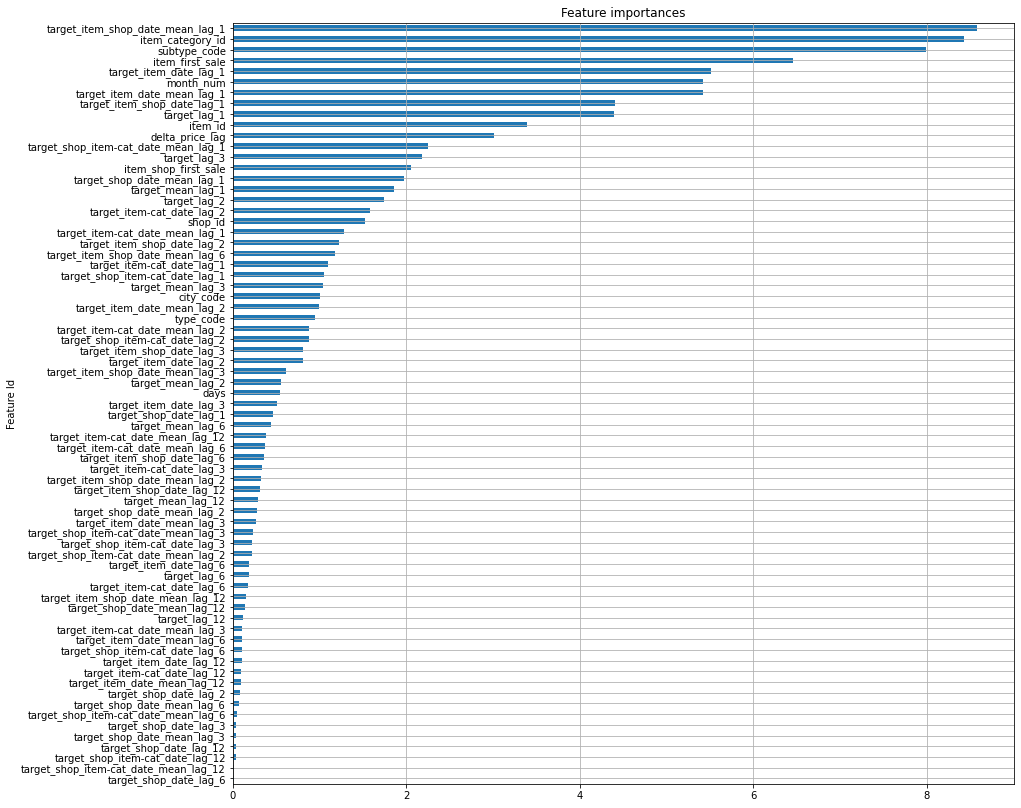

In [21]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(
    loss_function='RMSE',
    #cat_features=cat_features,
    #l2_leaf_reg=6,
    depth=8,
    #learning_rate=0.1,
    #iterations=10000,
    iterations=1000,
    task_type='CPU',
    random_state=43,
)
model_cbr.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    verbose=10, 
    #early_stopping_rounds=500,
    early_stopping_rounds=30,
    plot=True,
)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(14,14), legend=False, grid=True, title="Feature importances");

In [22]:
# model_cbr.get_all_params()

[14:24:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05679	validation_1-rmse:1.05128
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[5]	validation_0-rmse:0.86719	validation_1-rmse:0.93073
[10]	validation_0-rmse:0.84523	validation_1-rmse:0.92384
[15]	validation_0-rmse:0.82992	validation_1-rmse:0.92417
[20]	validation_0-rmse:0.82328	validation_1-rmse:0.92267
[25]	validation_0-rmse:0.81744	validation_1-rmse:0.91946
[30]	validation_0-rmse:0.81306	validation_1-rmse:0.91538
[35]	validation_0-rmse:0.81044	validation_1-rmse:0.91351
[40]	validation_0-rmse:0.80539	validation_1-rmse:0.91200
[45]	validation_0-rmse:0.80307	validation_1-rmse:0.910

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

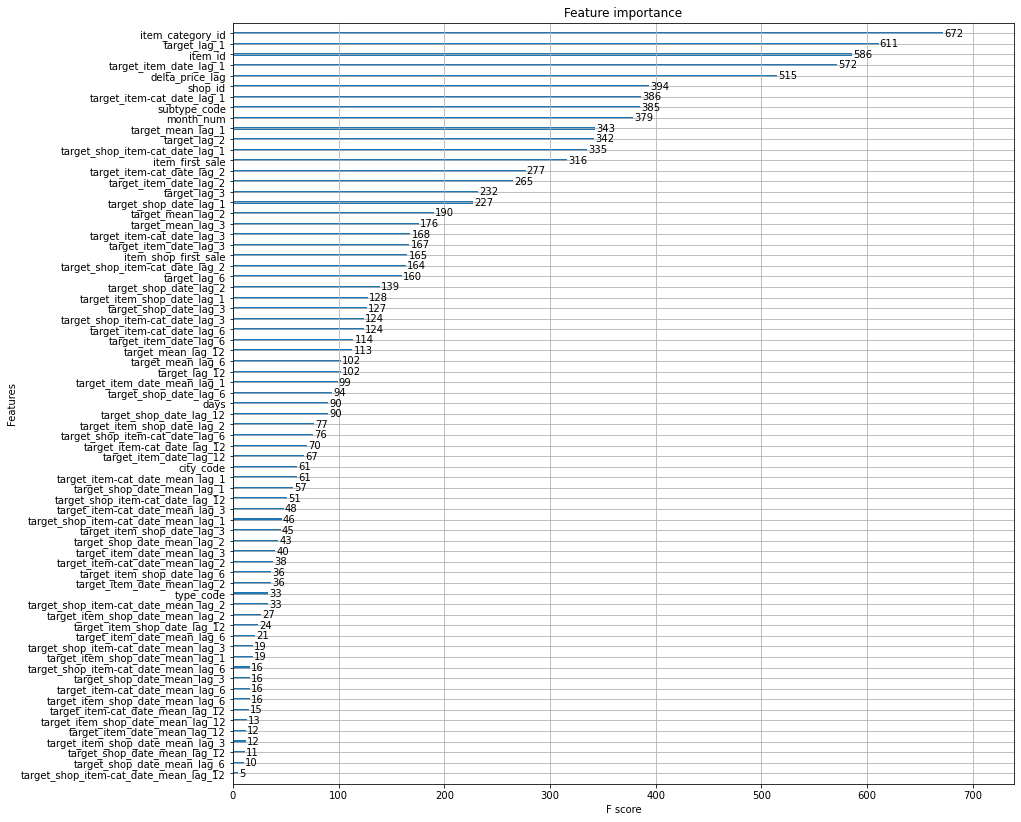

In [23]:
%%time
# xgboost
model_xgb = xgb.XGBRegressor(
    n_jobs=4, 
    random_state=43,
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
)

model_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric="rmse", 
    verbose=5, 
    early_stopping_rounds = 20
)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(14, 14))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [24]:
%%time
# RandomForest
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(
    criterion='mse',
    n_jobs=-1,
    n_estimators=50, 
    max_depth=8,
    random_state=47,
    verbose=10,
)

model_rf.fit(
    X_train, y_train, 
)
pred_rf = model_rf.predict(X_test)

print('\nTest R-squared for RandomForestRegressor is %f' % r2_score(y_test, pred_rf))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_rf)))
print()

# Save model to disk
if save_models:
    pickle.dump(model_rf, open('data/sa-model_rf.pkl', "wb"))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.9min


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.9min


building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  9.8min


building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.8min


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 17.5min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.6min


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s



Test R-squared for RandomForestRegressor is 0.308730
Test RMSE XGBoost is 0.944629

CPU times: user 1h 22min 48s, sys: 26.6 s, total: 1h 23min 15s
Wall time: 25min 2s


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


In [25]:
%%time
# KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
knn_features = ['target_item_date_lag_1', 'delta_price_lag', 
                'target_lag_1', 'target_lag_2', 'item_category_id', 'subtype_code', 'target_mean_lag_1',
                'target_item_date_mean_lag_1',  'target_item_shop_date_lag_1',
               'target_shop_date_mean_lag_1']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:400000]
y_train_sampled = y_train[:400000]

model_knr =  make_pipeline(
    ColumnTransformer([
         ('to_pass', 'passthrough', knn_features)
        ], remainder='drop', n_jobs=-1, verbose=True),
    MinMaxScaler(),
    KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')
)
model_knr.fit(X_train_sampled, y_train_sampled)
print('Model fitting done')
pred_knr = model_knr.predict(X_test)

print(f'Test KNeighborsRegressor is {np.sqrt(mean_squared_error(y_test, pred_knr)):.6f}')

if save_models:
    pickle.dump(model_knr, open('data/sa-model_knr.pkl', "wb"))

Model fitting done
Test KNeighborsRegressor is 0.991195
CPU times: user 4min 25s, sys: 1.46 s, total: 4min 27s
Wall time: 3min 45s


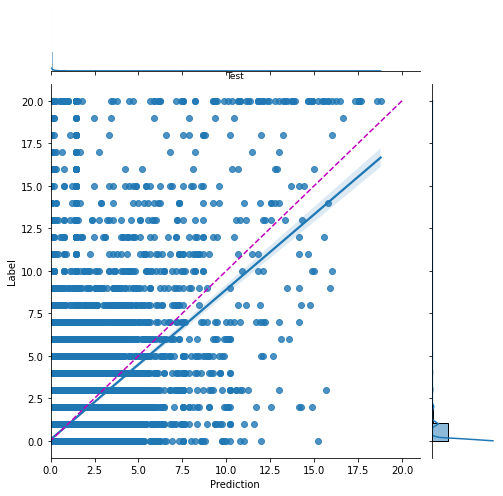

In [26]:
model_performance_sc_plot(pred_knr, y_test, 'Test')

## Load pickled predictors 

In [27]:
# Load pickled predictors
if save_models:
    model_lr   = pickle.load(open('data/sa-model_lr.pkl', "rb"))    # LinearRegression
    model_lgb  = pickle.load(open('data/sa-model_lgb.pkl', "rb"))   # LightGBM
    model_cbr  = pickle.load(open('data/sa-model_cbr.pkl', "rb"))   # CatBoost
    model_xgb  = pickle.load(open('data/sa-model_xgb.pkl', "rb"))   # xgboost
    model_br   = pickle.load(open('data/sa-model_br.pkl', "rb"))    # BayesianRidge
    model_sgdr = pickle.load(open('data/sa-model_sgdr.pkl', "rb"))  # SGDRegressor (decrease quality)
    model_en   = pickle.load(open('data/sa-model_en.pkl', "rb"))    # ElasticNetCV

In [28]:
%%time
# Make predictions for test data
train_lr  = model_lr.predict(X_train)
train_lgb = model_lgb.predict(X_train)
train_cbr = model_cbr.predict(X_train)
train_xgb = model_xgb.predict(X_train)
train_br  = model_br.predict(X_train)
# train_sgdr= model_sgdr.predict(X_train)
train_en  = model_en.predict(X_train)

X_train_level2 = np.c_[train_lr, train_lgb, train_cbr, train_xgb, train_br, train_en] 
# X_train_level2 = np.c_[train_lr, train_cbr, train_xgb] 
# X_test_level2.tofile('X_test_level2')
print('Train L2 data shape:', X_train_level2.shape)

Train L2 data shape: (6186922, 6)
CPU times: user 4min 27s, sys: 6.6 s, total: 4min 34s
Wall time: 1min 27s


In [29]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lr  = model_lr.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)
test_br  = model_br.predict(X_test)
# test_sgdr= model_sgdr.predict(X_test)
test_en  = model_en.predict(X_test)

X_test_level2 = np.c_[test_lr, test_lgb, test_cbr, test_xgb, test_br, test_en]
# X_test_level2 = np.c_[test_lr, test_cbr, test_xgb]
print('Test L2 data shape:', X_test_level2.shape)

Test L2 data shape: (238172, 6)
CPU times: user 11.7 s, sys: 473 ms, total: 12.2 s
Wall time: 3.53 s


In [30]:
%%time
# Make prediction for target data
target_lr  = model_lr.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)
target_br  = model_br.predict(X_target)
# target_sgdr= model_sgdr.predict(X_target)
target_en  = model_en.predict(X_target)

X_target_level2 = np.c_[target_lr, target_lgb, target_cbr, target_xgb, target_br, target_en]
# X_target_level2 = np.c_[target_lr, target_cbr, target_xgb]
print('Target L2 data shape:', X_target_level2.shape)

Target L2 data shape: (214200, 6)
CPU times: user 11.2 s, sys: 516 ms, total: 11.7 s
Wall time: 3.62 s


# Let's make L2 predictions

In [31]:
%%time
l2_model_lr = LinearRegression()
l2_model_lr.fit(X_train_level2, y_train)
test_l2_lr = l2_model_lr.predict(X_test_level2)

print(f'Test RMSE for LinearRegression L2 is {np.sqrt(mean_squared_error(y_test, test_l2_lr)):.6f}')

Test RMSE for LinearRegression L2 is 0.908925
CPU times: user 1.23 s, sys: 476 ms, total: 1.71 s
Wall time: 876 ms


In [32]:
from sklearn.linear_model import ElasticNetCV
l2_model_en = ElasticNetCV()
l2_model_en.fit(X_train_level2, y_train)
test_l2_en = l2_model_en.predict(X_test_level2)

print(f'Test RMSE for ElasticNet L2 is {np.sqrt(mean_squared_error(y_test, test_l2_en)):.6f}')

Test RMSE for ElasticNet L2 is 0.908172


In [33]:
%%time
# BayesianRidge regression
from sklearn.linear_model import BayesianRidge
l2_model_br = BayesianRidge()
l2_model_br.fit(X_train_level2, y_train)
test_l2_br = l2_model_br.predict(X_test_level2)

# print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test BayesianRidge L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_br)))

Test BayesianRidge L2 is 0.908933
CPU times: user 6.7 s, sys: 2.59 s, total: 9.29 s
Wall time: 2.98 s


In [34]:
%%time
# LassoCV
from sklearn.linear_model import LassoCV

l2_model_lcv = LassoCV(n_jobs=4, random_state=43)

l2_model_lcv.fit(X_train_level2, y_train)
test_l2_lcv = l2_model_lcv.predict(X_test_level2)

print('Test LassoCV L2 is %f' % np.sqrt(mean_squared_error(y_test, test_l2_lcv)))

Test LassoCV L2 is 0.908397
CPU times: user 2min 19s, sys: 19.1 s, total: 2min 38s
Wall time: 51.3 s


In [35]:
%%time
l2_model_cb = cb.CatBoostRegressor(
    loss_function='RMSE',
    task_type='CPU',
    #depth=8,
    #learning_rate=0.001,
    #l2_leaf_reg=6,
)
l2_model_cb.fit(X_train_level2, y=y_train,
                eval_set=(X_test_level2, y_test),
                early_stopping_rounds=20,
                verbose=20,
                use_best_model=True,
                plot=True)
test_l2_cbr = l2_model_cb.predict(X_test_level2)

print()
print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')
print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0485327	test: 1.0371013	best: 1.0371013 (0)	total: 379ms	remaining: 6m 18s
20:	learn: 0.7980791	test: 0.9411779	best: 0.9193678 (6)	total: 7.95s	remaining: 6m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9193678127
bestIteration = 6

Shrink model to first 7 iterations.

Test RMSE for CatBoost L2 is 0.9193678126610022
Test RMSE for CatBoost L2 is 0.9193678126610022
CPU times: user 43.3 s, sys: 2.23 s, total: 45.5 s
Wall time: 20.1 s


In [36]:
# l2_model_cb.get_all_params()

## Prepare data to Kaggle

In [37]:
# Make submission

# Insert your model here
pred_model = l2_model_en # ElasticNetCV

tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
# export_pred = l2_model_lr.predict(X_target_level2)

export_pred = pred_model.predict(X_target_level2)
# export_pred = np.round(export_pred)
kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data

kaggle_data shape: (214200, 4)


,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.528244
1,1,5,5320,0.631200
2,2,5,5233,2.069533
3,3,5,5232,0.984671
4,4,5,5268,2.882366
...,...,...,...,...
214195,214195,45,18454,0.000000
214196,214196,45,16188,0.040920
214197,214197,45,15757,0.062556
214198,214198,45,19648,0.022355
